# YawDD 특화 코드  
# dataset 경로, 출력 파일 이름만 수정하면 다른 데이터셋에 대해서도 사용할 수 있습니다.

In [2]:
from collections import deque
import os
import numpy as np
import pandas as pd
import json
import cv2
import mediapipe as mp
import time

In [31]:
Normal_file_paths, Normal_file_names = [], []
Talking_file_paths, Talking_file_names = [], []
Yawning_file_paths, Yawning_file_names = [], []
for root, dirs, files in os.walk("./data/male"):
    for fname in files:
        if fname.endswith("Normal.avi"):
            Normal_file_paths.append(os.path.join(root, fname))
            Normal_file_names.append(fname)
        if fname.endswith("Talking.avi"):
            Talking_file_paths.append(os.path.join(root, fname))
            Talking_file_names.append(fname)
        if fname.endswith("Yawning.avi"):
            Yawning_file_paths.append(os.path.join(root, fname))
            Yawning_file_names.append(fname)

print(Normal_file_names)
print(Talking_file_names)
print(Yawning_file_names)

['1-MaleSunGlasses-Normal.avi', '10-MaleNoGlasses-Normal.avi', '11-MaleGlasses-Normal.avi', '12-MaleGlasses-Normal.avi', '13-MaleGlasses-Normal.avi', '14-MaleGlasses-Normal.avi', '15-MaleNoGlasses-Normal.avi', '16-MaleNoGlasses-Normal.avi', '17-MaleNoGlasses-Normal.avi', '18-MaleNoGlasses-Normal.avi', '19-MaleGlassesmoustache-Normal.avi', '2-MaleGlasses-Normal.avi', '20-MaleGlasses-Normal.avi', '21-MaleGlasses-Normal.avi', '22-MaleGlassesmoustache-Normal.avi', '23-MaleGlassesBeard-Normal.avi', '23-MaleNoGlasses-Normal.avi', '24-MaleGlasses-Normal.avi', '25-MaleGlasses-Normal.avi', '25-MaleSunGlasses-Normal.avi', '26-MaleNoGlasses-Normal.avi', '27-MaleGlasses-Normal.avi', '27-MaleNoGlasses-Normal.avi', '28-MaleGlasses-Normal.avi', '28-MaleNoGlasses-Normal.avi', '29-MaleNoGlasses-Normal.avi', '3-MaleGlasses-Normal.avi', '3-MaleNoGlasses-Normal.avi', '30-MaleGlasses-Normal.avi', '31-MaleGlasses-Normal.avi', '32-MaleGlasses-Normal.avi', '33-MaleGlasses-Normal.avi', '34-MaleNoGlasses-Normal

# 각종 변수 선언 파트

In [4]:
CALIB_SECONDS = 2.0       # 초기 캘리브레이션 구간(초)
FPS_FALLBACK = 30.0       # FPS 정보가 없을 때 기본값
SMOOTH_WIN = 5            # EAR/MAR 이동평균 윈도우
BLINK_MAX_FRAMES = 8      # blink로 볼 수 있는 최대 닫힘 프레임 길이
YAWN_MIN_FRAMES = 30      # 하품으로 간주할 최소 프레임 길이
HAND_MOUTH_DIST_PX = 80   # 손가락 포인트와 입 중심 간 근접 판정 거리(픽셀)

# 상태 머신 임계치 비율 (캘리브레이션 결과에 곱해 사용)
EYE_CLOSE_RATIO = 0.85    # 눈감김 임계치: EAR_low = median(EAR_calib)*EYE_CLOSE_RATIO
EYE_OPEN_RATIO  = 1.05    # 눈뜸 임계치: EAR_high = median(EAR_calib)*EYE_OPEN_RATIO
MOUTH_YAWN_RATIO = 1.25   # 하품 임계치: MAR_high = median(MAR_calib)*MOUTH_YAWN_RATIO

# 졸림 지표 윈도우(초)
PERCLOS_WIN_SEC = 10.0
RATE_WIN_SEC = 20.0

# 졸림 임계값(튜닝 가능)
PERCLOS_T1, PERCLOS_T2, PERCLOS_T3 = 0.20, 0.40, 0.60
YAWN_T1, YAWN_T2, YAWN_T3 = 2.0, 4.0, 6.0           # per minute
BLINK_DUR_T1, BLINK_DUR_T2, BLINK_DUR_T3 = 0.25, 0.35, 0.50  # seconds
LONG_EC_T1, LONG_EC_T2, LONG_EC_T3 = 0.5, 0.8, 1.0            # seconds

In [5]:
# FaceMesh / Hands 초기화
mp_face = mp.solutions.face_mesh
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

# FaceMesh 눈/입 계산용 랜드마크 인덱스 (MediaPipe FaceMesh)
# EAR: (상하 거리 합) / (좌우 거리)  -- 관례적 정의
LEFT_EYE = [33, 160, 158, 133, 153, 144]   # [left, top1, top2, right, bottom1, bottom2]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
# MAR: (상하 거리) / (좌우 거리)
MOUTH_HORZ = (61, 291)    # 좌우 외측 입꼬리
MOUTH_VERT = (13, 14)     # 상하(안쪽 입술 중앙)

# 상태 관련 버퍼
ear_buf = deque(maxlen=SMOOTH_WIN)
mar_buf = deque(maxlen=SMOOTH_WIN)

# 상태 머신 상수 (눈 + 하품)
EYE_OPEN, EYE_CLOSE, EYE_OPENING, EYE_CLOSING, EYE_BLINK = range(5)
YAWN_NONE, YAWN_WITH_HAND, YAWN_WITHOUT_HAND = 0, 1, 2

eye_state = EYE_OPEN    # 초기 가정
close_count = 0         # 연속 닫힘 프레임 수(블링크 판정용)
yawn_state = YAWN_NONE
yawn_count = 0

# 캘리브레이션 샘플
EAR_LOW, EAR_HIGH = 0.18, 0.26
MAR_HIGH = 0.60
ear_samples = []
mar_samples = []

# 졸림 지표 계산용 슬라이딩 버퍼 (초 단위 시간축)
closed_flags = deque()   # (t, 0/1) — 눈감김 여부
blink_events = deque()   # (t, duration_sec)
yawn_events  = deque()   # (t,)
active_close_start = None  # 현재 진행 중인 eye-closure 시작시간
active_blink_start = None  # blink용(짧은 닫힘)

# 졸음 단계 색상 팔레트
LEVEL_COLOR = {
    0: (0, 220, 0),     # alert - green
    1: (0, 200, 255),   # mild - orange
    2: (0, 128, 255),   # moderate - darker orange
    3: (0, 0, 255)      # severe - red
}

# 각종 상태 및 라벨을 판별하는 함수들 + ROI

In [6]:
def euclid(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def eye_aspect_ratio(lm, eye_idx, w, h):
    pts = [(lm[i].x*w, lm[i].y*h) for i in eye_idx]
    p1, p2, p3, p4, p5, p6 = pts
    vertical = (euclid(p2, p6)+euclid(p3, p5))/2.0
    horizontal = euclid(p1, p4)+1e-6
    return vertical / horizontal

def mouth_aspect_ratio(lm, w, h):
    L = (lm[MOUTH_HORZ[0]].x*w, lm[MOUTH_HORZ[0]].y*h)
    R = (lm[MOUTH_HORZ[1]].x*w, lm[MOUTH_HORZ[1]].y*h)
    U = (lm[MOUTH_VERT[0]].x*w, lm[MOUTH_VERT[0]].y*h)
    D = (lm[MOUTH_VERT[1]].x*w, lm[MOUTH_VERT[1]].y*h)
    horizontal = euclid(L, R) + 1e-6
    vertical = euclid(U, D)
    return vertical / horizontal, ((L[0]+R[0])/2, (U[1]+D[1])/2)

def moving_avg(buf, k):
    if len(buf)==0: return None
    return float(np.mean(list(buf)[-k:]))

def draw_roi(frame, pts, color=(0,255,0), thickness=2):
    xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
    x1, y1, x2, y2 = int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
    return (x1, y1, x2, y2)

def is_hand_near_mouth(hand_lm_list, mouth_center, max_dist_px, w, h):
    if hand_lm_list is None: return False
    cx, cy = mouth_center
    for hand in hand_lm_list:
        for lm in hand.landmark:
            px, py = lm.x*w, lm.y*h
            if euclid((px, py), (cx, cy)) <= max_dist_px:
                return True
    return False

def drowsiness_level(perclos, yawn_rate, avg_blink_dur, longest_ec):
    # 가장 심한 상태 조건을 우선 판단
    # Severe 우선
    if (perclos is not None and perclos > PERCLOS_T3) or \
       (yawn_rate is not None and yawn_rate > YAWN_T3) or \
       (longest_ec is not None and longest_ec >= LONG_EC_T3):
        return 3, "severe_drowsy"
    # Moderate
    if (perclos is not None and perclos > PERCLOS_T2) or \
       (yawn_rate is not None and yawn_rate > YAWN_T2) or \
       (avg_blink_dur is not None and avg_blink_dur > BLINK_DUR_T2) or \
       (longest_ec is not None and longest_ec >= LONG_EC_T2):
        return 2, "moderate_drowsy"
    # Mild
    if (perclos is not None and perclos > PERCLOS_T1) or \
       (yawn_rate is not None and yawn_rate > YAWN_T1) or \
       (avg_blink_dur is not None and avg_blink_dur > BLINK_DUR_T1) or \
       (longest_ec is not None and longest_ec >= LONG_EC_T1):
        return 1, "mild_drowsy"
    # Alert
    return 0, "alert"

# 영상 라벨링 분석을 위한 자동 함수화

In [7]:
def drowsiness_labeling(cap, output, logs, fps, width, height):
    with mp_face.FaceMesh(
       static_image_mode=False,
       refine_landmarks=True,
       max_num_faces=1,
       min_detection_confidence=0.5,
       min_tracking_confidence=0.5
       ) as face_mesh, mp_hands.Hands(
       static_image_mode=False,
       max_num_hands=2,
       min_detection_confidence=0.5,
       min_tracking_confidence=0.5
    ) as hands:
       global EAR_HIGH, EAR_LOW, MAR_HIGH

       frame_idx = 0
       eye_state = EYE_OPEN    # 초기 가정
       close_count = 0         # 연속 닫힘 프레임 수(블링크 판정용)
       yawn_state = YAWN_NONE
       yawn_count = 0

       active_close_start = None  # 현재 진행 중인 eye-closure 시작시간
       active_blink_start = None  # blink용(짧은 닫힘)

       ear_buf.clear()
       mar_buf.clear()
       blink_events.clear()
       yawn_events.clear()
       closed_flags.clear()

       while True:
              ret, frame = cap.read()
              if not ret: break
              frame_idx += 1
              t_sec = frame_idx / fps

              rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              face_res = face_mesh.process(rgb)
              hands_res = None  # 조건부로 돌려도 됨(여기선 항상 실행)

              label_id = 0
              label_str = "eyes_state/open"

              if face_res.multi_face_landmarks:
                     face_landmarks = face_res.multi_face_landmarks[0].landmark

                     # EAR/MAR
                     ear_l = eye_aspect_ratio(face_landmarks, LEFT_EYE, width, height)
                     ear_r = eye_aspect_ratio(face_landmarks, RIGHT_EYE, width, height)
                     ear = (ear_l + ear_r) / 2.0
                     mar, mouth_center = mouth_aspect_ratio(face_landmarks, width, height)

                     ear_buf.append(ear)
                     mar_buf.append(mar)
                     ear_s = moving_avg(ear_buf, SMOOTH_WIN)
                     mar_s = moving_avg(mar_buf, SMOOTH_WIN)

                     # 캘리브레이션 샘플 수집
                     if frame_idx <= int(CALIB_SECONDS * fps):
                            ear_samples.append(ear)
                            mar_samples.append(mar)
                            if frame_idx == int(CALIB_SECONDS * fps):
                                   if len(ear_samples) >= 5:
                                          ear_med = float(np.median(ear_samples))
                                          EAR_LOW  = ear_med * EYE_CLOSE_RATIO
                                          EAR_HIGH = ear_med * EYE_OPEN_RATIO
                                   if len(mar_samples) >= 5:
                                          mar_med = float(np.median(mar_samples))
                                          MAR_HIGH = mar_med * MOUTH_YAWN_RATIO

                     # 손-입 근접
                     hands_res = hands.process(rgb)
                     hand_near = is_hand_near_mouth(
                            hands_res.multi_hand_landmarks if hands_res else None,
                            mouth_center, HAND_MOUTH_DIST_PX, width, height
                     )

                     # 눈 상태 머신
                     prev_state = eye_state
                     if ear_s is None:
                            eye_state = EYE_OPEN
                     else:
                            if len(ear_buf) >= 3:
                                   ear_deriv = ear_buf[-1] - ear_buf[-3]
                            else:
                                   ear_deriv = 0.0

                            is_closed = ear_s < EAR_LOW
                            is_opened = ear_s > EAR_HIGH

                            if is_closed:
                                   eye_state = EYE_CLOSE if prev_state == EYE_CLOSE else (EYE_CLOSING if ear_deriv < 0 else EYE_CLOSE)
                                   close_count += 1
                            elif is_opened:
                                   eye_state = EYE_OPEN if prev_state == EYE_OPEN else (EYE_OPENING if ear_deriv > 0 else EYE_OPEN)
                                   # blink 판정
                                   if 0 < close_count <= BLINK_MAX_FRAMES:
                                          eye_state = EYE_BLINK
                                   close_count = 0
                            else:
                                   eye_state = EYE_OPENING if ear_deriv > 0 else (EYE_CLOSING if ear_deriv < 0 else prev_state)
                                   if prev_state in (EYE_CLOSE, EYE_CLOSING):
                                          close_count += 1
                                   else:
                                          close_count = 0

                     # 하품 상태
                     if mar_s is not None and mar_s > MAR_HIGH:
                            yawn_count += 1
                            yawn_state = YAWN_WITH_HAND if hand_near else YAWN_WITHOUT_HAND
                     else:
                            yawn_state = YAWN_NONE
                            yawn_count = 0

                     # 최종 행동 라벨
                     if yawn_state != YAWN_NONE and yawn_count >= YAWN_MIN_FRAMES:
                            if yawn_state == YAWN_WITH_HAND:
                                   label_id, label_str = 5, "yawning/Yawning with hand"
                            else:
                                   label_id, label_str = 6, "yawning/Yawning without hand"
                     else:
                            if   eye_state == EYE_OPEN:    label_id, label_str = 0, "eyes_state/open"
                            elif eye_state == EYE_CLOSE:   label_id, label_str = 1, "eyes_state/close"
                            elif eye_state == EYE_OPENING: label_id, label_str = 2, "eyes_state/opening"
                            elif eye_state == EYE_CLOSING: label_id, label_str = 3, "eyes_state/closing"
                            elif eye_state == EYE_BLINK:   label_id, label_str = 4, "blinks/blinking"

                     # ====== 졸림 지표 업데이트 ======
                     # A) PERCLOS: 최근 PERCLOS_WIN_SEC 동안 '눈감김' 비율
                     closed_flag = 1 if ear_s is not None and ear_s < EAR_LOW else 0
                     closed_flags.append((t_sec, closed_flag))
                     while closed_flags and (t_sec - closed_flags[0][0] > PERCLOS_WIN_SEC):
                            closed_flags.popleft()
                     if closed_flags:
                            perclos = sum(f for _, f in closed_flags) / float(len(closed_flags))
                     else:
                            perclos = None

                     # B) blink 이벤트 기록(짧은 닫힘)
                     # blink가 찍히는 순간(eye_state == EYE_BLINK)에서 duration 계산
                     # 간단히: 방금 전까지의 close_count를 duration으로 사용
                     if eye_state == EYE_BLINK:
                            blink_dur = close_count / fps  # 방금 열림과 함께 close_count가 0으로 초기화되기 전에 계산됨
                            blink_events.append((t_sec, blink_dur))
                     # 창구 유지
                     while blink_events and (t_sec - blink_events[0][0] > RATE_WIN_SEC):
                            blink_events.popleft()

                     if blink_events:
                            blink_rate = len(blink_events) * (60.0 / RATE_WIN_SEC)  # per 20s
                            avg_blink_dur = float(np.mean([d for _, d in blink_events]))
                     else:
                            blink_rate = 0.0
                            avg_blink_dur = None

                     # C) 긴 eye-closure 감지(연속 close가 길면 이벤트로 기록)
                     # close 연속 구간의 시작/끝 추적
                     if closed_flag == 1 and active_close_start is None:
                            active_close_start = t_sec
                     if closed_flag == 0 and active_close_start is not None:
                            dur = t_sec - active_close_start
                            blink_events.append((t_sec, dur))  # 긴 eye closure도 blink_events에 포함시켜 평균/최대에 반영
                            active_close_start = None
                     # longest eye closure (최근 RATE_WIN_SEC)
                     if blink_events:
                            longest_ec = max(d for _, d in blink_events)
                     else:
                            longest_ec = None

                     # D) yawn 이벤트(프레임 지속 충족 시 시점 기록)
                     if yawn_state != YAWN_NONE and yawn_count == YAWN_MIN_FRAMES:
                            yawn_events.append((t_sec,))
                     while yawn_events and (t_sec - yawn_events[0][0] > RATE_WIN_SEC):
                            yawn_events.popleft()
                     yawn_rate = len(yawn_events) * (60.0 / RATE_WIN_SEC) if yawn_events else 0.0

                     # ====== 졸림 단계 산출 ======
                     d_level, d_label = drowsiness_level(perclos, yawn_rate, avg_blink_dur, longest_ec)

                     # ====== 시각화 ======
                     cv2.putText(frame, f"Label {label_id}: {label_str}", (20, 40),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 200, 255), 2)
                     if ear_s is not None:
                            cv2.putText(frame, f"EAR:{ear_s:.3f} (L:{EAR_LOW:.3f} H:{EAR_HIGH:.3f})",
                                          (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
                     if mar_s is not None:
                            cv2.putText(frame, f"MAR:{mar_s:.3f} (Y>{MAR_HIGH:.3f})",
                                          (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,200,0), 2)

                     # 졸림 지표/단계 표시
                     c = LEVEL_COLOR[d_level]
                     cv2.putText(frame, f"Drowsiness {d_level}: {d_label}", (20, 135),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, c, 2)
                     cv2.putText(frame, f"PERCLOS:{(perclos if perclos is not None else np.nan):.2f}  "
                                          f"Yawn/min:{yawn_rate:.1f}  "
                                          f"Blink/min:{blink_rate:.1f}  "
                                          f"AvgBlinkDur:{(avg_blink_dur if avg_blink_dur else np.nan):.2f}s  "
                                          f"LongestEC:{(longest_ec if longest_ec else np.nan):.2f}s",
                                   (20, 165), cv2.FONT_HERSHEY_SIMPLEX, 0.3, c, 2)

              else:
                     # 얼굴 미검출 시
                     label_id, label_str = 0, "eyes_state/open"
                     d_level, d_label = 0, "alert"
                     perclos = None; yawn_rate = 0.0; blink_rate = 0.0; avg_blink_dur = None; longest_ec = None
                     cv2.putText(frame, "Face not detected", (20, 40),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 2)

              # ====== 로그 저장 ======
              logs.append({
                     "frame": frame_idx,
                     "time_sec": t_sec,
                     "label_id": label_id,
                     "label_name": label_str,
                     "EAR": float(ear_buf[-1]) if len(ear_buf)>0 else np.nan,
                     "MAR": float(mar_buf[-1]) if len(mar_buf)>0 else np.nan,
                     "yawn_rate_per_min": float(yawn_rate),
                     "blink_rate_per_min": float(blink_rate) if face_res.multi_face_landmarks else 0.0,
                     "avg_blink_dur_sec": float(avg_blink_dur) if avg_blink_dur is not None else np.nan,
                     "longest_eye_closure_sec": float(longest_ec) if longest_ec is not None else np.nan,
                     "drowsiness_level": d_level,
                     "drowsiness_label": d_label
              })

              output.write(frame)
    return logs

# 영상 라벨링 수행
## Normal, Talking, Yawning 구분에 따라 다른 for문 시작점 사용

In [ ]:
#for video_path, video_name in zip(Normal_file_paths, Normal_file_names):
#for video_path, video_name in zip(Talking_file_paths,Talking_file_names):
for video_path, video_name in zip(Yawning_file_paths, Yawning_file_names):
       # 미리 저장된 영상을 사용
       cap = cv2.VideoCapture(video_path)  

       fps = cap.get(cv2.CAP_PROP_FPS)
       if fps <= 1e-2: fps = FPS_FALLBACK
       width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
       height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
       total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap.get(cv2.CAP_PROP_FRAME_COUNT)>0 else None

       fourcc = cv2.VideoWriter_fourcc(*"mp4v")
       output_name = video_name.replace(".avi", "-labeled.avi")
       out = cv2.VideoWriter("./output/"+ output_name, fourcc, fps, (width, height))

       logs = []

       # 캘리브 구간 프레임 수
       calib_frames = int(CALIB_SECONDS * fps)

       output_log = drowsiness_labeling(cap, out, logs, fps, width, height)

       cap.release()
       out.release()
       cv2.destroyAllWindows()

       pd.DataFrame(output_log).to_csv("./output/"+output_name.replace(".avi", ".csv"), index=False)
       print(f"Saved video: {"./output/"+output_name}")
       print(f"Saved CSV:   {"./output/"+output_name.replace(".avi", ".csv")}")

Saved video: ./output/1-FemaleNoGlasses-Yawning-labeled.avi
Saved CSV:   ./output/1-FemaleNoGlasses-Yawning-labeled.csv
Saved video: ./output/10-FemaleNoGlasses-Yawning-labeled.avi
Saved CSV:   ./output/10-FemaleNoGlasses-Yawning-labeled.csv


KeyboardInterrupt: 

# csv log 파일 → segment 정보를 담은 json 파일화

In [29]:
# csv 파일의 이름 및 경로를 normal, yawning 구분에 따라 나눠서 취합 후 저장

normal_csv_file_paths, normal_csv_file_names = [], []
yawning_csv_file_paths, yawning_csv_file_names = [], []
for root, dirs, files in os.walk("."):
    for fname in files:
        if fname.endswith("Normal-label.csv"):
            normal_csv_file_paths.append(os.path.join(root, fname))
            normal_csv_file_names.append(fname)
        if fname.endswith("Yawning-label.csv"):
            yawning_csv_file_paths.append(os.path.join(root, fname))
            yawning_csv_file_names.append(fname)
            
print(normal_csv_file_names)
print(yawning_csv_file_names)

['10-MaleNoGlasses-Normal-label.csv', '11-MaleGlasses-Normal-label.csv', '12-MaleGlasses-Normal-label.csv', '13-MaleGlasses-Normal-label.csv', '14-MaleGlasses-Normal-label.csv', '15-MaleNoGlasses-Normal-label.csv', '16-MaleNoGlasses-Normal-label.csv', '17-MaleNoGlasses-Normal-label.csv', '18-MaleNoGlasses-Normal-label.csv', '19-MaleGlassesmoustache-Normal-label.csv', '2-MaleGlasses-Normal-label.csv', '20-MaleGlasses-Normal-label.csv', '21-MaleGlasses-Normal-label.csv', '22-MaleGlassesmoustache-Normal-label.csv', '23-MaleGlassesBeard-Normal-label.csv', '23-MaleNoGlasses-Normal-label.csv', '24-MaleGlasses-Normal-label.csv', '25-MaleGlasses-Normal-label.csv', '26-MaleNoGlasses-Normal-label.csv', '27-MaleGlasses-Normal-label.csv', '27-MaleNoGlasses-Normal-label.csv', '28-MaleGlasses-Normal-label.csv', '28-MaleNoGlasses-Normal-label.csv', '29-MaleNoGlasses-Normal-label.csv', '3-MaleGlasses-Normal-label.csv', '3-MaleNoGlasses-Normal-label.csv', '30-MaleGlasses-Normal-label.csv', '31-MaleGlas

In [ ]:
# segment화 json 파일 생성 부분
# csv 파일을 읽은 후 → drowsiness level에 따라 구역을 segment화 시켜 각 구간의 길이를 계산
def make_segments(df, frame_col, label_col, time_col, insert_gaps=True):
    d = df.sort_values(by=frame_col).reset_index(drop=True).copy()
    d[frame_col] = d[frame_col].astype(int)
    d[time_col] = round(d[time_col].astype(float), 3)
    d[label_col] = d[label_col].astype(int)
    if d.empty: 
        return []

    segs = []
    start = int(d.loc[0, frame_col])
    start_time = float(d.loc[0, time_col])
    prev_frame = start
    prev_label = int(d.loc[0, label_col])

    for i in range(1, len(d)):
        f = int(d.loc[i, frame_col])
        t = float(d.loc[i, time_col])
        lab = int(d.loc[i, label_col])
        # 프레임 갭(누락 프레임) 처리
        if f != prev_frame + 1:
            segs.append({"start": start, "end": prev_frame + 1, "label": prev_label, "note": "프레임 누락"})
            if insert_gaps and f > prev_frame + 1:
                segs.append({"start": prev_frame + 1, "end": f, "label": -1, "note": "무시"})  # 전이/무시
            start, start_time, prev_frame, prev_label = f, t, f, lab
            continue
        # 라벨 변경 경계
        if lab != prev_label:
            segs.append({"start": start, "end": f, "label": prev_label, "note": f"시간 표현: {start_time} ~ {t}"})
            start, start_time, prev_label = f, t, lab
        prev_frame = f

    segs.append({"start": start, "end": prev_frame + 1, "label": prev_label, "note": f"시간 표현: {start_time} ~ {t}"})
    return segs

def convert_csv_to_segments_json(csv_path, out_json_path, fps=30):
    df = pd.read_csv(csv_path)
    df = df[["frame", "time_sec", "drowsiness_level", "drowsiness_label"]]

    segments = make_segments(df, "frame", "drowsiness_level", "time_sec", insert_gaps=True)
    num_frames = int(df["frame"].max()) + 1

    friendly = {0:"정상", 1:"의심", 2:"주의", 3:"위험", -1:"무시"}
    class_map = [{"id": int(i), "name": friendly.get(int(i))} for i in friendly]

    payload = {
        "schema_version": "1.0",
        "dataset": {
            "id": os.path.splitext(os.path.basename(csv_path))[0],
            "source": csv_path,
            "fps": fps,
            "num_frames": num_frames,
            "timebase": "frame"
        },
        "segments": segments,
        "class_map": class_map,
        "meta": {
            "annotator": "auto-convert + human-verified",
            "created_at": pd.Timestamp.now().strftime("%Y-%m-%dT%H:%M:%SZ"),
            "comments": "half-open [start,end) rule; gaps labeled -1"
        }
    }
    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

In [33]:
#for video_path, video_name, csv_path, csv_name in zip(Normal_file_paths, Normal_file_names, normal_csv_file_paths,normal_csv_file_names):
for video_path, video_name, csv_path, csv_name in zip(Yawning_file_paths, Yawning_file_names, yawning_csv_file_paths, yawning_csv_file_names):
    cap = cv2.VideoCapture(video_path)  

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 1e-2: fps = FPS_FALLBACK
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap.get(cv2.CAP_PROP_FRAME_COUNT)>0 else None

    convert_csv_to_segments_json(csv_path=csv_path, 
                                 out_json_path='./output/male/segment/'+csv_name.replace('.csv', '.json'),
                                 fps=fps)

In [11]:
daf = pd.read_csv(normal_csv_file_paths[0])
daf = daf[["frame", "time_sec", "drowsiness_level", "drowsiness_label"]]
daf["time_sec"] = round(daf["time_sec"], 3)
daf

,frame,time_sec,drowsiness_level,drowsiness_label
0,1,0.033,0,alert
1,2,0.067,0,alert
2,3,0.100,0,alert
3,4,0.133,0,alert
4,5,0.167,0,alert
...,...,...,...,...
414,415,13.847,2,moderate_drowsy
415,416,13.881,2,moderate_drowsy
416,417,13.914,2,moderate_drowsy
417,418,13.947,2,moderate_drowsy


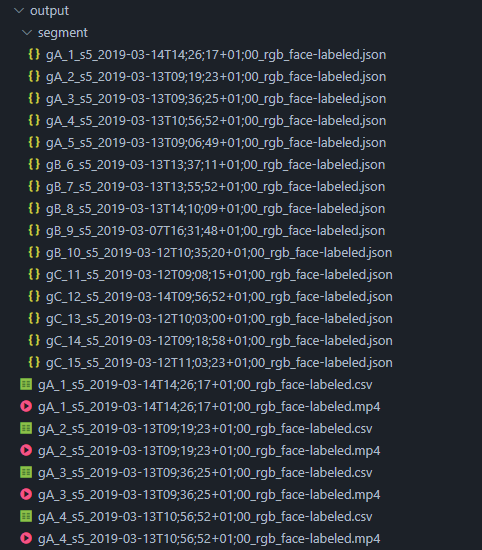  
YawDD output 폴더의 경우, 다음과 같이 구성되어있습니다. 경로 구성에 참고해주세요.